# Series

A ``Series`` object is a collection of 1D arrays, all of which share a common index. Under the hood, it wraps an n-dimensional array, and supports either distributed operations via Spark or local operations via `numpy`, with an identical API. The final dimension of the array indexes the series, and the initial dimensions are arbitrary.

The most common `series` data is time series data, in which case the index is time and each record is a different signal, like a channel or pixel.

Here, we show examples of loading and manipulating `series` data.

## Setup plotting


In [1]:
%matplotlib inline

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')
from showit import image

In [3]:
import thunder as td

## Loading series

`series` data can be loaded using the `td.series.from*` methods, which support loading from a few different formats. Here we'll load example data.

In [4]:
series = td.series.fromexample('fish')

## Inspection

Let's plot a random subset of the data using the `sample` method, after filtering by standard deviation

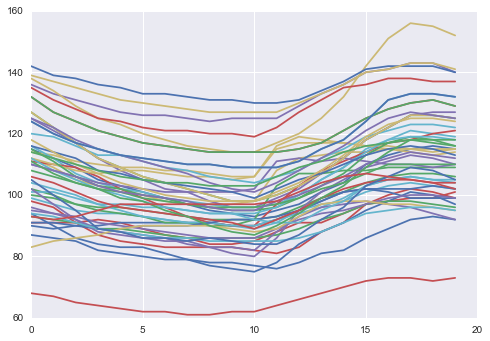

In [5]:
examples = series.filter(lambda x: x.std() > 4).sample(n=50).toarray()
plt.plot(examples.T);

Note the variation in raw intensity levels.

## Processing

A `Series` object has various methods for processing and transforming data. For example, `center` subtracts the mean, `squelch` sets to 0 any records not exceeding a threshold, and `zscore` subtracts the mean and divides by the standard deviation. Note the changes in the y-axis.

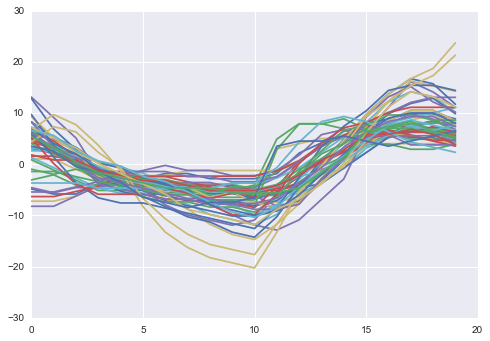

In [6]:
examples = series.filter(lambda x: x.std() > 4).center().sample(n=50).toarray()
plt.plot(examples.T);

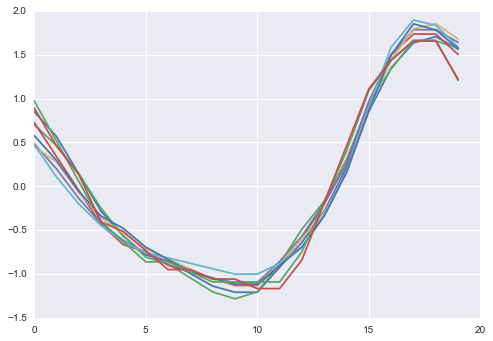

In [7]:
examples = series.squelch(150).zscore().filter(lambda x: x.std() > 0.1).toarray()
plt.plot(examples.T);

Related methods include `standardize`, `detrend`, and `normalize`.

Selections
----------
A ``Series`` has a 1D index, which can be used to subselect values.

In [8]:
series.index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

For example, to select a range:

In [9]:
series.between(0,8).shape

(76, 87, 2, 8)

Note that the index changes to reflect the subselected range:

In [10]:
series.between(0,8).index

[0, 1, 2, 3, 4, 5, 6, 7]

In this case we could have also just use bracket notation

In [11]:
series[:, :, :, 0:8].shape

(76, 87, 2, 8)

But explicitly referencing the index can be useful when the index encodes information (see below).

We can also select based on an arbitrary criterion function:

In [12]:
series.select(lambda x: x < 5).index

[0, 1, 2, 3, 4]

The default index generated for ``Series`` objects will be the range of integers starting at zero and ending one before the length of the series data, as shown in these examples. However, other data types can also be used as the index for a series object, such as a sequence of strings, providing text labels for each element in the series array, or a tuple with indices at different levels.

## Statistics

A `series` can be summarized with statistics both within and across records. To summarize across records:

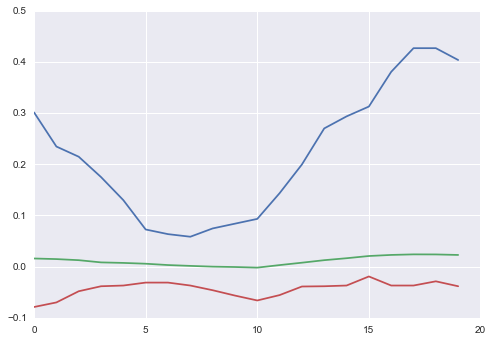

In [13]:
plt.plot(series.normalize().max());
plt.plot(series.normalize().mean());
plt.plot(series.normalize().min());

To compute statistics within records, we can make use of the `map` method, which executes an artbirary function on each record

In [14]:
means = series.map(lambda x: x.mean()).flatten().toarray()
stds = series.map(lambda x: x.std()).flatten().toarray()

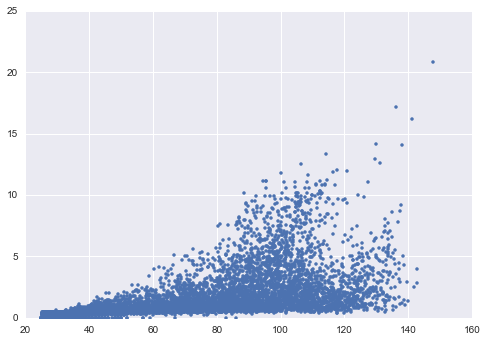

In [15]:
plt.plot(means, stds, '.');

We can also correlate each record with a signal of interest. As expected, for a random signal, the correlation should be near 0.

In [16]:
from numpy import random
signal = random.randn(20)
correlations = series.filter(lambda x: x.std() > 0).correlate(signal).flatten().toarray()

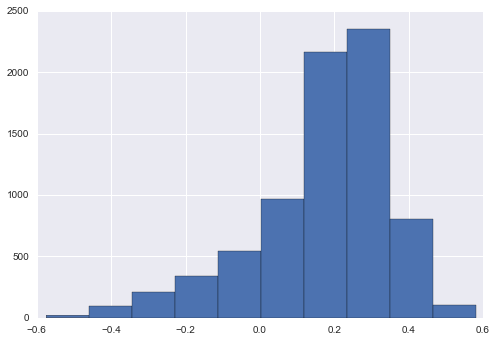

In [17]:
plt.hist(correlations);

We can use the `fourier` method to compute the statistics of a Fourier transform

In [18]:
fourier = series.filter(lambda x: x.std() > 1).flatten().fourier(freq=1)
fourier.index

['coherence', 'phase']

And plot `phase` as a function of `coherence`

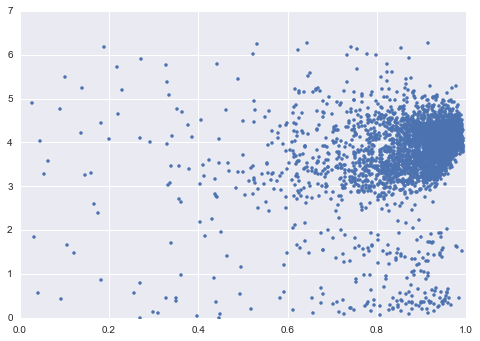

In [19]:
plt.plot(fourier.select('coherence').toarray(), fourier.select('phase').toarray(), '.')

We can also `detrend` over time, which will remove the periodic structure

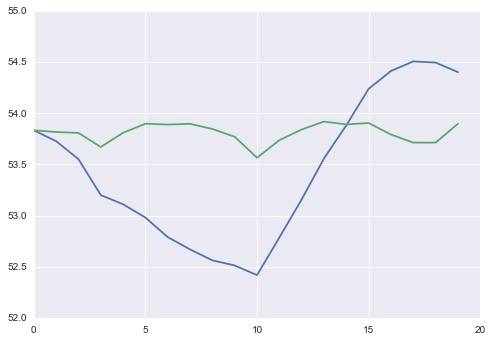

In [20]:
plt.plot(series.mean())
plt.plot(series.detrend('nonlinear', order=5).mean());

And we can compute a covariance matrix.

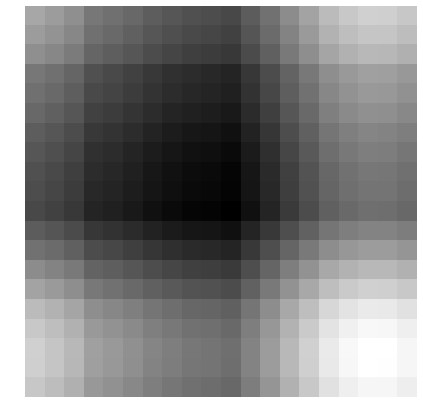

In [21]:
image(series.flatten().cov());

There are more methods on `series` data, and algorithm packages that take `series` data as input. See the other tutorials and documentation for more!